In [1]:
# dependencies

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nfx.custom.binomial
import nfx.misc.plot

sns.set()

In [6]:
# helper functions

def package_samples(samples, node_names, covariate_names, meta):

    coef_samples, prec_samples = zip(*samples)
    coef_samples = [np.array(coef_samples_) for coef_samples_ in zip(*coef_samples)][::-1]
    prec_samples = np.trace(prec_samples, axis1=2, axis2=3).T[::-1]
    return package_coef_samples(coef_samples, node_names, covariate_names, meta), package_prec_samples(prec_samples, meta)

def package_coef_samples(coef_samples, node_names, covariate_names, meta):

    dfs = []
    for i, (coef_samples_, node_names_) in enumerate(zip(coef_samples, node_names)):
        for j, node_names__ in enumerate(node_names_):
            df_ = pd.DataFrame(coef_samples_[:, j].T, index=covariate_names)
            df_.index = df_.index.rename('covariate')
            df_.columns = df_.columns.rename('iter')
            for k, v in meta.items():
                df_[k] = v
            df_['level'] = i
            df_['node'] = node_names__.zfill(i + 1)
            dfs.append(df_)
    df = pd.concat(dfs).reset_index().set_index(['level', 'node', 'covariate'] + list(meta.keys()))
    return df

def package_prec_samples(prec_samples, meta):

    df = pd.DataFrame(prec_samples, index=np.arange(len(prec_samples)))
    df.index = df.index.rename('level')
    df.columns = df.columns.rename('iter')
    for k, v in meta.items():
        df[k] = v
    df = df.reset_index().set_index(['level'] + list(meta.keys()))
    return df

def est_acf(samples, n_lags):

    acf = samples.apply(lambda x: nfx.misc.plot.est_acf(x.values, n_lags), 1, False, 'expand')
    acf.columns = acf.columns.rename('lag')
    return acf

def est_ess(acfs, titer):
    
    df = pd.DataFrame(index=acfs.index)
    df['iat[iter]'] = acfs.apply(lambda x: nfx.misc.plot.est_int_autocor(x.values), 1, False, 'expand').rename('iat')
    df['iat[sec]'] = df['iat[iter]'] * titer
    df['rate[iter]'] = 1 / (2 * df['iat[iter]'])
    df['rate[sec]'] = df['rate[iter]'] / titer
    return df

In [7]:
# config

covariate_names = ['housing']
seed = 0

In [8]:
# load data

macro = pd.read_csv('paper/data/sareb_covariates.csv').set_index('time')
prices = pd.read_csv('paper/data/sareb_prices_synthetic.csv').set_index('zip')
rng = np.random.default_rng(seed)

In [9]:
# format response

response = prices.diff(axis=1).dropna(axis=1) > 0

In [10]:
# format covariates

covariates = macro.loc[:, covariate_names]
covariates['_constant'] = 1
covariates['_trend'] = np.arange(covariates.shape[0])
covariates = covariates.loc[:, ['_trend', 'housing']].diff().dropna().loc[response.columns]

In [11]:
# construct tree

indices = response.index.to_frame()
indices['lvl_1'] = indices.zip.str.slice(0, 2)
indices['lvl_2'] = indices.zip.str.slice(0, 3)
indices['lvl_3'] = indices.zip.str.slice(0, 4)
indices['lvl_4'] = indices.zip.str.slice(0, 5)
indices = indices.drop('zip', 1)
codes = indices.apply(lambda x: x.astype('category').cat.codes).astype('int64')
n_nodes = codes.max(0) + 1
parent_node_3 = codes[['lvl_4', 'lvl_3']].drop_duplicates().lvl_3
parent_node_2 = codes[['lvl_3', 'lvl_2']].drop_duplicates().lvl_2
parent_node_1 = codes[['lvl_2', 'lvl_1']].drop_duplicates().lvl_1
tree = [parent_node_3, parent_node_2, parent_node_1]
node_names = [['0'], indices.lvl_1.unique(), indices.lvl_2.unique(), indices.lvl_3.unique(), indices.lvl_4.unique()]

/tmp/ipykernel_293637/2691591494.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  indices = indices.drop('zip', 1)


In [12]:
# sample sla

n_samples = 10000
sampler = nfx.custom.binomial.sample_posterior(response.values, np.ones_like(response.values), covariates.values, tree, ome=rng)
samples = [next(sampler)[:2] for _ in  range(10 + n_samples)][10:]

In [13]:
# compute sla summaries

coef_samples, prec_samples = package_samples(samples, node_names, ['_trend'] + covariate_names, {'algo_name': 'SLA'})
coef_acf, prec_acf = (est_acf(samples_, 256) for samples_ in (coef_samples, prec_samples))
coef_ess, prec_ess = (est_ess(acfs_, 1) for acfs_ in (coef_acf, prec_acf))

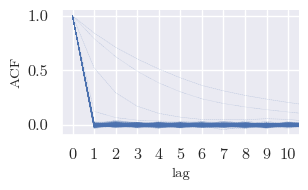

In [37]:
acf = pd.concat([coef_acf, prec_acf]).reset_index().set_index(['algo_name', 'level', 'node', 'covariate'])
iat = acf.apply(lambda x: nfx.misc.plot.est_int_autocor(x.values), 1, False, 'expand').rename('iat')
rank = iat.rank(ascending=False)
#acf = acf.loc[(acf.columns.astype(float) < 10) | (acf.columns.astype(float) % 10 == 0)].reset_index()
acf = acf.loc[(rank < 20) | (rank % 20 == 0)].reset_index()
acf['param_ix'] = acf.index
acf_long = acf.melt(id_vars=['algo_name', 'level', 'node', 'covariate', 'param_ix'], var_name='lag').dropna(subset=['value'])
acf_long['type'] = acf_long.node.isna()

g = sns.relplot(data=acf_long, x='lag', y='value', kind='line', style='param_ix', legend=False, height=2, aspect=8/5, alpha=1/3, lw=1/3)
g.set(xlabel='lag', ylabel='ACF', xlim=(-.5, 10.5))
g.set_titles(col_template='{col_name}')